In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = 'data/wustl_iiot_2021.csv'
df = pd.read_csv(dataset_path)

In [3]:
df.head()

,StartTime,LastTime,SrcAddr,DstAddr,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,...,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct,Traffic,Target
0,2019-08-19 12:23:28,2019-08-19 12:23:28,192.168.0.20,192.168.0.2,0,59034,502,10,8,18,...,24,20,44,0.001176,0.053037,0,0.000000,0.0,normal,0
1,2019-08-19 15:13:24,2019-08-19 15:13:24,192.168.0.20,192.168.0.2,0,55841,502,10,8,18,...,24,20,44,0.001308,0.052681,0,0.000000,0.0,normal,0
2,2019-08-19 13:41:31,2019-08-19 13:41:31,192.168.0.20,192.168.0.2,0,63774,502,10,8,18,...,24,20,44,0.000690,0.051793,0,0.000000,0.0,normal,0
3,2019-08-19 12:43:19,2019-08-19 12:43:20,209.240.235.92,192.168.0.2,0,61771,80,4,0,4,...,0,0,0,0.000000,0.889555,0,419.338813,0.0,DoS,1
4,2019-08-19 14:49:44,2019-08-19 14:49:48,192.168.0.20,192.168.0.1,3,0,0,14,0,14,...,476,0,476,0.000000,3.500055,0,525.146562,0.0,normal,0


In [4]:
# Remove columns as per the dataset's note and Traffic - the target detail.
columns_to_remove = ['StartTime', 'LastTime', 'SrcAddr', 'DstAddr', 'sIpId', 'dIpId', 'Traffic']
df = df.drop(columns=columns_to_remove)

###### Check feature has Gaussian distribution

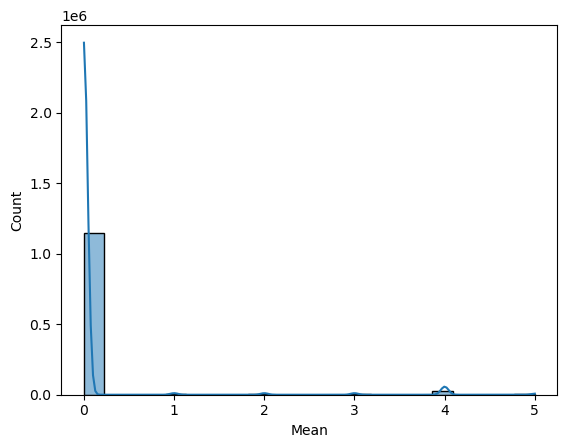

In [5]:
# 1. Method 1: Histogram with Density Curve
sns.histplot(df['Mean'], kde=True)
plt.show()
#If the curve resembles a bell shape, the feature may follow a Gaussian distribution.

In [6]:
# 2. Method 2: Descriptive Statistics
mean = df['Mean'].mean()
median = df['Mean'].median()

print(f"Mean: {mean}, Median: {median}")
if abs(mean - median) < (0.1 * mean):  # Example threshold
    print("Feature might follow a Gaussian distribution.")
else:
    print("Feature likely does not follow a Gaussian distribution.")
#If Mean ≈ Median, the data might follow a normal distribution.    

Mean: 0.12868700940338093, Median: 0.0
Feature likely does not follow a Gaussian distribution.


In [7]:
# 3. Method 3: Skewness Check
skewness = df['Mean'].skew()
print(f"Skewness: {skewness}")
if abs(skewness) < 0.5:  # Quick threshold
    print("Feature might be Gaussian.")
else:
    print("Feature likely not Gaussian.")
# Indicates symmetry, Close to 0 → Likely Gaussian.    

Skewness: 5.432740854511099
Feature likely not Gaussian.


In [8]:
# Separate features and target variable
X = df.drop('Target', axis=1)
y = df['Target']

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
#Convert categorical values to numerical values

lencoder=LabelEncoder()
def label_encode(data):
    data['Proto']=lencoder.fit_transform(data['Proto'])
    #data["Sport"] = lencoder.fit_transform(data["Sport"])
    #data["Dport"] = lencoder.fit_transform(data["Dport"])
    return data

In [11]:
X_train = label_encode(X_train)

In [12]:
X_test = label_encode(X_test)

In [13]:
# Apply SMOTE to balance classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [14]:
#Since most features doesn't have Gaussian distribution, used normalization.

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train_resampled)
X_test_normalized = scaler.transform(X_test)

In [15]:
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

In [16]:
X_train_normalized.head()

,Mean,Sport,Dport,SrcPkts,DstPkts,TotPkts,DstBytes,SrcBytes,TotBytes,SrcLoad,...,sTtl,dTtl,SAppBytes,DAppBytes,TotAppByte,SynAck,RunTime,sTos,SrcJitAct,DstJitAct
0,0.0,0.021502,0.007662,3.604946e-07,0.000026,6.488902e-07,0.000006,3.054092e-07,5.373825e-07,0.000073,...,0.501961,0.5,0.00024,2.446299e-07,1.024757e-08,0.000224,0.010745,0.0,0.0,0.0
1,0.0,0.022340,0.007662,3.604946e-07,0.000026,6.488902e-07,0.000006,3.054092e-07,5.373825e-07,0.000074,...,0.501961,0.5,0.00024,2.446299e-07,1.024757e-08,0.000216,0.010595,0.0,0.0,0.0
2,0.0,0.022820,0.007662,3.604946e-07,0.000026,6.488902e-07,0.000006,3.054092e-07,5.373825e-07,0.000078,...,0.501961,0.5,0.00024,2.446299e-07,1.024757e-08,0.000217,0.010062,0.0,0.0,0.0
3,0.0,0.022550,0.007662,3.604946e-07,0.000026,6.488902e-07,0.000006,3.054092e-07,5.373825e-07,0.000078,...,0.501961,0.5,0.00024,2.446299e-07,1.024757e-08,0.000217,0.010124,0.0,0.0,0.0
4,0.0,0.022028,0.007662,3.604946e-07,0.000026,6.488902e-07,0.000006,3.054092e-07,5.373825e-07,0.000077,...,0.501961,0.5,0.00024,2.446299e-07,1.024757e-08,0.000232,0.010204,0.0,0.0,0.0


In [17]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [18]:
rfe = RFE(estimator=rf, n_features_to_select=15)

In [19]:
sfs = SequentialFeatureSelector(rf, n_features_to_select=15, direction='forward')

In [20]:
rf.fit(X_train_normalized, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
# Predict on test set
y_pred = rf.predict(X_test_normalized)

In [23]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    221490
           1       1.00      1.00      1.00     17403

    accuracy                           1.00    238893
   macro avg       1.00      1.00      1.00    238893
weighted avg       1.00      1.00      1.00    238893

Accuracy Score:  0.9999497683063129


In [24]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

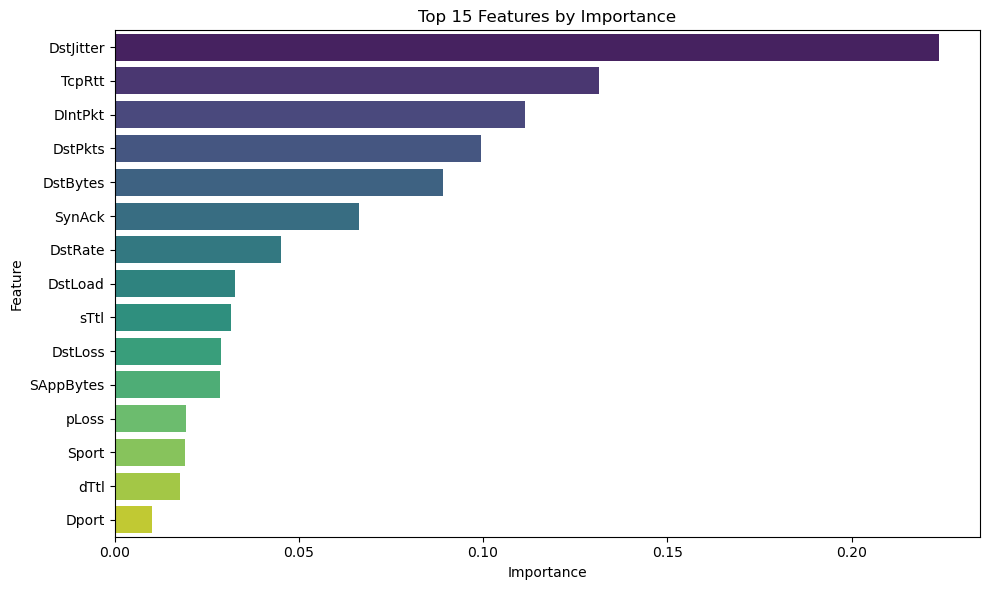

In [25]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [28]:
print(feature_importance)

       Feature  Importance
20   DstJitter    0.223659
25      TcpRtt    0.131535
22     DIntPkt    0.111514
4      DstPkts    0.099359
6     DstBytes    0.089029
36      SynAck    0.066369
13     DstRate    0.045145
10     DstLoad    0.032632
31        sTtl    0.031502
16     DstLoss    0.028951
33   SAppBytes    0.028544
18       pLoss    0.019431
1        Sport    0.019070
32        dTtl    0.017837
2        Dport    0.010274
29         Max    0.007477
27         Sum    0.006462
37     RunTime    0.004428
23       Proto    0.003710
11        Load    0.003534
28         Min    0.003374
21     SIntPkt    0.003334
9      SrcLoad    0.002960
26    IdleTime    0.002482
17        Loss    0.001585
14        Rate    0.001160
15     SrcLoss    0.001127
12     SrcRate    0.000997
8     TotBytes    0.000420
34   DAppBytes    0.000348
19   SrcJitter    0.000295
40   DstJitAct    0.000277
5      TotPkts    0.000275
39   SrcJitAct    0.000227
7     SrcBytes    0.000183
3      SrcPkts    0.000161
3

In [ ]:
X_train_rfe = rfe.fit_transform(X_train_normalized, y_train_resampled)
X_test_rfe = rfe.transform(X_test_normalized)

# Get selected features
selected_features = X.columns[rfe.get_support()]
print("Selected Features:")
print(selected_features)

In [ ]:
X_train_sfs = sfs.fit_transform(X_train_normalized, y_train_resampled)
X_test_sfs = sfs.transform(X_test_normalized)

# Get selected features
selected_features = X.columns[sfs.get_support()]
print("Selected Features:")
print(selected_features)